## Импорты и настройка окружения

In [1]:
import os
import time
import re
from enum import Enum


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mlflow
from mlflow.models.signature import infer_signature

from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms

from tqdm import tqdm, trange
from pyngrok import ngrok



In [2]:
os.environ["GIT_PYTHON_REFRESH"] = "quiet"
import git
torch.cuda.is_available()

False

In [3]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


## Трансформация

In [4]:
distortion_scale = 0.3

In [29]:
transform = transforms.Compose([
    transforms. ElasticTransform(alpha=70.0 ),
    transforms.RandomRotation(degrees=30.0),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 1)),
    #transforms.RandomPerspective(p=0.9, distortion_scale=distortion_scale),
    #transforms.RandomResizedCrop(size=(28, 28),scale=(0.7, 0.8), ratio=(0.7, 0.8)),
    transforms.ToTensor()
])

In [30]:
def get_transform():
    try:
        transform
    except NameError:
        return transforms.Compose([transforms.ToTensor()])
    else:
        return transform

In [31]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt_ax.imshow(inp)
    
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Погрузка и настройка данных

In [32]:
generator1 = torch.Generator().manual_seed(42)

dataset_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataset_train_augm = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
dataset = torch.utils.data.ConcatDataset(
    [dataset_train, dataset_train_augm]
)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator1)

DEVICE = torch.device("cpu")

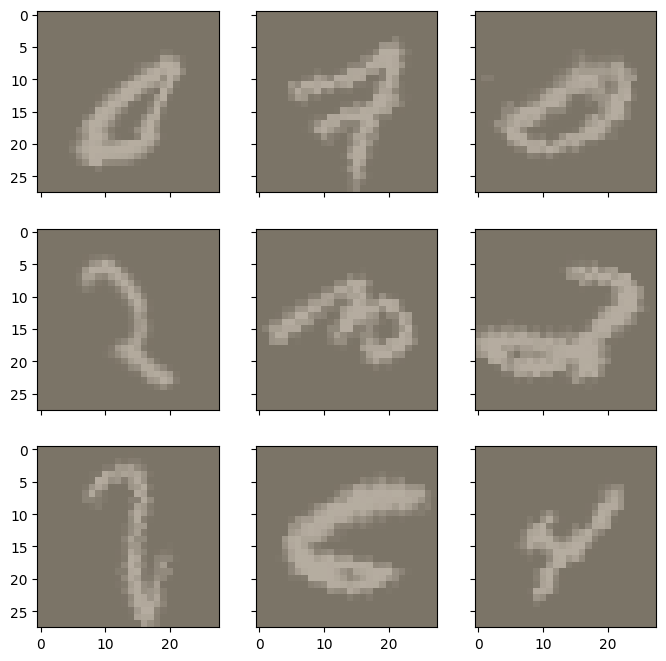

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset_train_augm[random_characters]
    
    imshow(im_val.data.cpu(), plt_ax=fig_x)

## Методы обучения, предсказания и оценки

In [34]:
class Timer:
    def __enter__(self):
        self._start = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self._end = time.time()

    def __str__(self):
        num = self.float_round()
        return f'{num} seconds'
    
    def float_round(self, cnt_numbers: int = 4) -> float:
        return round(self._end - self._start, cnt_numbers)

In [35]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data_count = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data_count += inputs.size(0)

    train_loss = running_loss / processed_data_count
    train_acc = running_corrects.cpu().numpy() / processed_data_count

    return train_loss, train_acc

In [36]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [37]:
def train(train_files, val_files, model, epochs: int, batch_size: int, num_samples: int):
    train_sampler=torch.utils.data.RandomSampler(train_dataset, num_samples=num_samples)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler) # shuffle=True,
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [38]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            if isinstance(inputs, tuple) or isinstance(inputs, list) and len(inputs) == 2:
                # if the loader is really loader, then it returns tuple(X, y)
                inputs = inputs[0]

            inputs = inputs.to(DEVICE)
            model.eval()
            
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Архитектуры

### Архитектура EnsNet

In [14]:
class EnsNet(nn.Module):
  def __init__(self, num_classes=10):
      super(EnsNet, self).__init__()
      self.features = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.35),
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(512, 1024, kernel_size=3),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        
      )
      self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
      self.classifier_major = nn.Linear(216, num_classes)
      self.classifiers = nn.ModuleList([
          nn.Linear(216, num_classes)
          for _ in range(10)
      ])
      self.weights = nn.Parameter(torch.ones(11) / 11, requires_grad=True)

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x_major = self.classifier_major(x[:, :216])
    x_rest = [classifier(x[:, 216 * i :216 * (i + 1) ]) for i, classifier in enumerate(self.classifiers)]
    all_x = torch.stack([x_major] + x_rest, dim=1)
    weighted_x = torch.sum(all_x * self.weights.view(1, -1, 1), dim=1)
    return weighted_x

### AlexNet

In [40]:
class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
         
        )
    
    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x

### VGG8

In [39]:
class VGG8(nn.Module):
    def __init__(self):
        super(VGG8, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=(3,3)),  nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv3 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.conv5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(5184, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(64, 128), nn.ReLU())
        self.fc3 = nn.Linear(128,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### ResNet

In [17]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )
  def forward(self, x):
    out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = nn.ReLU(inplace=True)(out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 16

    self.model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
      self._make_layer(16, 2, stride=1),
      self._make_layer(32, 2, stride=2),
      self._make_layer(64, 2, stride=2),
      self._make_layer(128, 2, stride=2),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(start_dim=1),
      nn.Linear(128, num_classes)
  )
    self._initialize_weights()

  def _make_layer(self, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

### LeNet

In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(3136, 120), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84), nn.ReLU())
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### Подгрузка модели

In [16]:
class NNNetEnum(Enum):
    ens_net = 1
    alex_net = 2
    vgg8 = 3
    res_net = 4
    le_net = 5

In [17]:
def get_nn_model(nn_model: NNNetEnum):
    model_class = None
    if nn_model == NNNetEnum.ens_net:
        model_class =  EnsNet
    if nn_model == NNNetEnum.alex_net:
        model_class =  AlexNet
    if nn_model == NNNetEnum.vgg8:
        model_class =  VGG8
    if nn_model == NNNetEnum.res_net:
        model_class =  ResNet
    if nn_model == NNNetEnum.le_net:
        model_class =  LeNet

    if model_class is None:
        raise Exception(f'The passed architecture {nn_model} was not found. Check enum conditions.')
    
    return model_class().to(DEVICE)

## Тесты архитектур

In [18]:
simple_cnn = get_nn_model(NNNetEnum.le_net)

In [19]:
epoch = 40
batch_size = 64
num_samples = 5000

In [20]:
with Timer() as train_timer:
    history = train(train_dataset, val_dataset, model=simple_cnn, epochs=epoch, batch_size=batch_size, num_samples=num_samples)

epoch:   0%|                                                                                    | 0/40 [00:00<?, ?it/s]

loss 1.5446465084075929


epoch:   2%|█▉                                                                          | 1/40 [00:29<19:03, 29.33s/it]


Epoch 001 train_loss: 1.5446     val_loss 0.9070 train_acc 0.4734 val_acc 0.6883
loss 0.7475187007904053


epoch:   5%|███▊                                                                        | 2/40 [00:58<18:31, 29.25s/it]


Epoch 002 train_loss: 0.7475     val_loss 0.6653 train_acc 0.7550 val_acc 0.7790
loss 0.5814426034927368


epoch:   8%|█████▋                                                                      | 3/40 [01:27<18:02, 29.27s/it]


Epoch 003 train_loss: 0.5814     val_loss 0.5092 train_acc 0.8140 val_acc 0.8315
loss 0.4604209532737732


epoch:  10%|███████▌                                                                    | 4/40 [01:57<17:37, 29.37s/it]


Epoch 004 train_loss: 0.4604     val_loss 0.4571 train_acc 0.8454 val_acc 0.8478
loss 0.414718639087677


epoch:  12%|█████████▌                                                                  | 5/40 [02:26<17:10, 29.43s/it]


Epoch 005 train_loss: 0.4147     val_loss 0.3858 train_acc 0.8666 val_acc 0.8813
loss 0.3664621339797974


epoch:  15%|███████████▍                                                                | 6/40 [02:56<16:45, 29.57s/it]


Epoch 006 train_loss: 0.3665     val_loss 0.4681 train_acc 0.8854 val_acc 0.8470
loss 0.35502244604229927


epoch:  18%|█████████████▎                                                              | 7/40 [03:26<16:17, 29.62s/it]


Epoch 007 train_loss: 0.3550     val_loss 0.3232 train_acc 0.8828 val_acc 0.8975
loss 0.32505944995880126


epoch:  20%|███████████████▏                                                            | 8/40 [03:55<15:44, 29.51s/it]


Epoch 008 train_loss: 0.3251     val_loss 0.3432 train_acc 0.9006 val_acc 0.8910
loss 0.3126880997657776


epoch:  22%|█████████████████                                                           | 9/40 [04:24<15:12, 29.43s/it]


Epoch 009 train_loss: 0.3127     val_loss 0.2925 train_acc 0.9050 val_acc 0.9072
loss 0.30471830151081086


epoch:  25%|██████████████████▊                                                        | 10/40 [04:54<14:42, 29.41s/it]


Epoch 010 train_loss: 0.3047     val_loss 0.2927 train_acc 0.9012 val_acc 0.9073
loss 0.27249718180298804


epoch:  28%|████████████████████▋                                                      | 11/40 [05:23<14:12, 29.38s/it]


Epoch 011 train_loss: 0.2725     val_loss 0.2790 train_acc 0.9090 val_acc 0.9105
loss 0.26812297649383543


epoch:  30%|██████████████████████▌                                                    | 12/40 [05:54<13:52, 29.72s/it]


Epoch 012 train_loss: 0.2681     val_loss 0.2636 train_acc 0.9164 val_acc 0.9162
loss 0.2765586144447327


epoch:  32%|████████████████████████▍                                                  | 13/40 [06:23<13:23, 29.74s/it]


Epoch 013 train_loss: 0.2766     val_loss 0.2580 train_acc 0.9096 val_acc 0.9164
loss 0.2392433893799782


epoch:  35%|██████████████████████████▎                                                | 14/40 [06:53<12:54, 29.78s/it]


Epoch 014 train_loss: 0.2392     val_loss 0.2473 train_acc 0.9216 val_acc 0.9236
loss 0.23696450428962706


epoch:  38%|████████████████████████████▏                                              | 15/40 [07:23<12:22, 29.70s/it]


Epoch 015 train_loss: 0.2370     val_loss 0.2178 train_acc 0.9244 val_acc 0.9312
loss 0.22728160581588744


epoch:  40%|██████████████████████████████                                             | 16/40 [07:53<11:56, 29.87s/it]


Epoch 016 train_loss: 0.2273     val_loss 0.2411 train_acc 0.9280 val_acc 0.9210
loss 0.26116338112950327


epoch:  42%|███████████████████████████████▉                                           | 17/40 [08:23<11:26, 29.84s/it]


Epoch 017 train_loss: 0.2612     val_loss 0.2648 train_acc 0.9182 val_acc 0.9132
loss 0.21086936421394348


epoch:  45%|█████████████████████████████████▊                                         | 18/40 [08:53<10:56, 29.83s/it]


Epoch 018 train_loss: 0.2109     val_loss 0.2047 train_acc 0.9340 val_acc 0.9346
loss 0.21640672569274902


epoch:  48%|███████████████████████████████████▋                                       | 19/40 [09:23<10:27, 29.88s/it]


Epoch 019 train_loss: 0.2164     val_loss 0.2178 train_acc 0.9332 val_acc 0.9303
loss 0.21694258946180345


epoch:  50%|█████████████████████████████████████▌                                     | 20/40 [09:53<09:57, 29.87s/it]


Epoch 020 train_loss: 0.2169     val_loss 0.2275 train_acc 0.9314 val_acc 0.9274
loss 0.2092399337053299


epoch:  52%|███████████████████████████████████████▍                                   | 21/40 [10:22<09:27, 29.89s/it]


Epoch 021 train_loss: 0.2092     val_loss 0.2086 train_acc 0.9308 val_acc 0.9344
loss 0.21303543446063997


epoch:  55%|█████████████████████████████████████████▎                                 | 22/40 [10:52<08:55, 29.75s/it]


Epoch 022 train_loss: 0.2130     val_loss 0.1949 train_acc 0.9302 val_acc 0.9357
loss 0.21776635402441025


epoch:  57%|███████████████████████████████████████████▏                               | 23/40 [11:22<08:26, 29.79s/it]


Epoch 023 train_loss: 0.2178     val_loss 0.2168 train_acc 0.9324 val_acc 0.9283
loss 0.1886867332816124


epoch:  60%|█████████████████████████████████████████████                              | 24/40 [11:52<07:57, 29.82s/it]


Epoch 024 train_loss: 0.1887     val_loss 0.2152 train_acc 0.9382 val_acc 0.9314
loss 0.17706629605293273


epoch:  62%|██████████████████████████████████████████████▉                            | 25/40 [12:22<07:29, 30.00s/it]


Epoch 025 train_loss: 0.1771     val_loss 0.1948 train_acc 0.9454 val_acc 0.9377
loss 0.1789806528568268


epoch:  65%|████████████████████████████████████████████████▊                          | 26/40 [12:51<06:56, 29.76s/it]


Epoch 026 train_loss: 0.1790     val_loss 0.2732 train_acc 0.9392 val_acc 0.9115
loss 0.2019269094340503


epoch:  68%|██████████████████████████████████████████████████▋                        | 27/40 [13:20<06:24, 29.56s/it]


Epoch 027 train_loss: 0.2019     val_loss 0.2071 train_acc 0.9358 val_acc 0.9343
loss 0.19787092344760895


epoch:  70%|████████████████████████████████████████████████████▌                      | 28/40 [13:49<05:52, 29.40s/it]


Epoch 028 train_loss: 0.1979     val_loss 0.1886 train_acc 0.9386 val_acc 0.9400
loss 0.18317289118766786


epoch:  72%|██████████████████████████████████████████████████████▍                    | 29/40 [14:18<05:22, 29.29s/it]


Epoch 029 train_loss: 0.1832     val_loss 0.2033 train_acc 0.9354 val_acc 0.9345
loss 0.17769911344647407


epoch:  75%|████████████████████████████████████████████████████████▎                  | 30/40 [14:47<04:52, 29.22s/it]


Epoch 030 train_loss: 0.1777     val_loss 0.1884 train_acc 0.9436 val_acc 0.9408
loss 0.1800137658238411


epoch:  78%|██████████████████████████████████████████████████████████▏                | 31/40 [15:17<04:22, 29.17s/it]


Epoch 031 train_loss: 0.1800     val_loss 0.1795 train_acc 0.9422 val_acc 0.9430
loss 0.16831003613471984


epoch:  80%|████████████████████████████████████████████████████████████               | 32/40 [15:46<03:53, 29.14s/it]


Epoch 032 train_loss: 0.1683     val_loss 0.1753 train_acc 0.9484 val_acc 0.9459
loss 0.19155308141708374


epoch:  82%|█████████████████████████████████████████████████████████████▉             | 33/40 [16:15<03:23, 29.12s/it]


Epoch 033 train_loss: 0.1916     val_loss 0.2065 train_acc 0.9430 val_acc 0.9338
loss 0.1797897385120392


epoch:  85%|███████████████████████████████████████████████████████████████▊           | 34/40 [16:44<02:54, 29.14s/it]


Epoch 034 train_loss: 0.1798     val_loss 0.1820 train_acc 0.9436 val_acc 0.9415
loss 0.17516656165122985


epoch:  88%|█████████████████████████████████████████████████████████████████▋         | 35/40 [17:13<02:26, 29.30s/it]


Epoch 035 train_loss: 0.1752     val_loss 0.1552 train_acc 0.9488 val_acc 0.9503
loss 0.16116457676887513


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 36/40 [17:43<01:57, 29.41s/it]


Epoch 036 train_loss: 0.1612     val_loss 0.1686 train_acc 0.9478 val_acc 0.9469
loss 0.18796770503520965


epoch:  92%|█████████████████████████████████████████████████████████████████████▍     | 37/40 [18:13<01:28, 29.56s/it]


Epoch 037 train_loss: 0.1880     val_loss 0.1887 train_acc 0.9386 val_acc 0.9402
loss 0.17707763820886613


epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 38/40 [18:43<00:59, 29.73s/it]


Epoch 038 train_loss: 0.1771     val_loss 0.1779 train_acc 0.9384 val_acc 0.9449
loss 0.16619869883060456


epoch:  98%|█████████████████████████████████████████████████████████████████████████▏ | 39/40 [19:13<00:29, 29.81s/it]


Epoch 039 train_loss: 0.1662     val_loss 0.1720 train_acc 0.9458 val_acc 0.9474
loss 0.169485884436965


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [19:43<00:00, 29.59s/it]


Epoch 040 train_loss: 0.1695     val_loss 0.1636 train_acc 0.9472 val_acc 0.9475


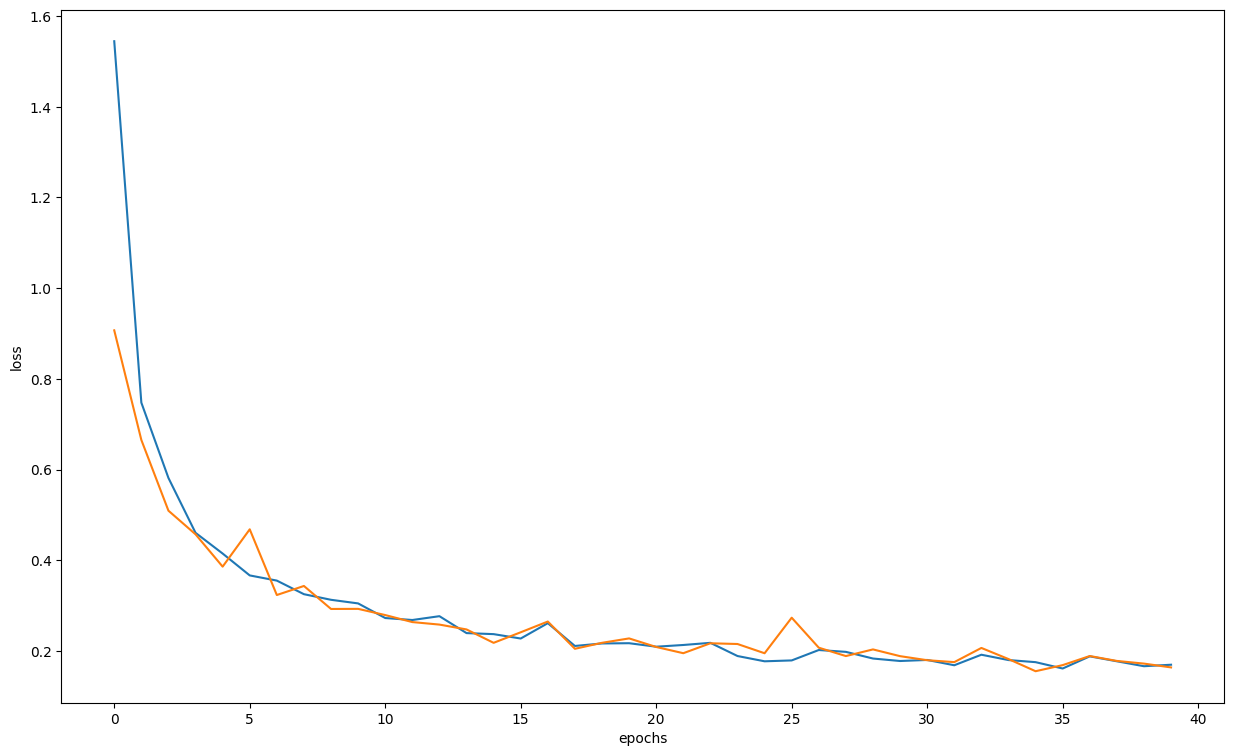

In [21]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [22]:
test_img = [test_dataset[i][0].unsqueeze(0) for i in range(len(test_dataset))]

with Timer() as test_timer:
    test_pred = predict(simple_cnn, test_img)
    y_pred = np.argmax(test_pred,-1)


#### Accuracy по классам

In [23]:
proba_ = predict(simple_cnn, DataLoader(test_dataset, batch_size=1, shuffle=False))
predict_ = np.argmax(proba_, -1)
actual_labels = [el[1] for el in test_dataset]

matrix = confusion_matrix(actual_labels, predict_)
ac_class = matrix.diagonal() / matrix.sum(axis=1)
print('ACCURACY', list(ac_class))

ACCURACY [0.9897959183673469, 0.986784140969163, 0.9874031007751938, 0.994059405940594, 0.9419551934826884, 0.9932735426008968, 0.9937369519832986, 0.9688715953307393, 0.9825462012320328, 0.9871159563924677]


#### Общий accuracy

In [24]:
actual_labels =[test_dataset[i][1] for i in range(len(test_dataset))]

ac = accuracy_score(actual_labels, y_pred)

print("ACCURACY general:", ac, 'ACCURACY by classes:', sum(ac_class) / 10)

ACCURACY general: 0.9825 ACCURACY by classes: 0.9825542007074421


In [25]:
simple_cnn.__class__.__name__

'LeNet'

In [26]:
params = {"epoch": epoch, "batch_size": batch_size}

for transform_el in get_transform().transforms:
    val = re.sub(r'\w+\(', '', str(transform_el))[:-1]
    
    if not val:
        continue
    
    if transform_el.__class__.__name__=='RandomPerspective':
        val=f'{val}, distortion_scale={distortion_scale}'
    print(val)
    params[transform_el.__class__.__name__] = val

print(params)

alpha=[60.0, 60.0], sigma=[5.0, 5.0], interpolation=InterpolationMode.BILINEAR, fill=[0.0]
degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0
{'epoch': 40, 'batch_size': 64, 'ElasticTransform': 'alpha=[60.0, 60.0], sigma=[5.0, 5.0], interpolation=InterpolationMode.BILINEAR, fill=[0.0]', 'RandomRotation': 'degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0'}


## Логирование в MLFlow

In [28]:
model_name = simple_cnn.__class__.__name__

params = {"epoch": epoch, "batch_size": batch_size, "num_samples": num_samples}

for transform_el in get_transform().transforms:
    val = re.sub(r'\w+\(', '', str(transform_el))[:-1]
    
    if not val:
        continue

    if transform_el.__class__.__name__=='RandomPerspective':
        val=f'{val}, distortion_scale={distortion_scale}'
    
    params[transform_el.__class__.__name__] = val


mlflow.set_tracking_uri(uri="sqlite:///mlruns.db")
mlflow.set_experiment(model_name)


with mlflow.start_run(run_name=model_name):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metric
    mlflow.log_metric("accuracy", ac)
    mlflow.log_metric("train_time_seconds", train_timer.float_round())
    mlflow.log_metric("pred_time_seconds", test_timer.float_round())

    for i in range(10):
         mlflow.log_metric(f"accuracy_{i}", round(ac_class[i], 5))

    # Log the model
    model_info = mlflow.pytorch.log_model(
        pytorch_model=simple_cnn,
        artifact_path=model_name,
        #signature = infer_signature(train_set_array, train_pred),
        #input_example=train_set_array,
        registered_model_name=model_name,
    )

Registered model 'LeNet' already exists. Creating a new version of this model...
Created version '95' of model 'LeNet'.
